# Predictive Maintenance using Machine Learning on Sagemaker
*Part 2 - Exploratory data analysis*

## Initialization
---
Directory structure to run this notebook:
```
nasa-turbofan-rul-deepar
|
+--- data
|   |
|   +--- interim: intermediate data we can manipulate and process
|   |
|   \--- raw: *immutable* data downloaded from the source website
|
+--- notebooks: all the notebooks are positionned here
|
+--- src: utility python modules are stored here
```

In [1]:
import matplotlib.pyplot as plt
import sagemaker
import boto3
import os
import errno
import pandas as pd
import seaborn as sns

sns.set_style('darkgrid')
%matplotlib inline
figures = []

### Loading data from the previous notebook

In [2]:
# Load data from the notebook local storage:
%store -r train_data
%store -r test_data

# If the data are not present in the notebook local storage, we need to load them from disk:
success_msg = 'Loaded "train_data"'
if 'train_data' not in locals():
    try:
        local_path = '../data/interim'
        train_data = pd.read_csv(os.path.join(local_path, 'train_data.csv'))
        train_data = train_data.set_index(['unit_number', 'time'])
        
        print('Train data file found on disk')
        print(success_msg)
            
    except Exception as e:
        if (e.errno == errno.ENOENT):
            print('Files not found to load train data from: you need to execute the previous notebook.')
            
else:
    print('Train data found in the notebook environment')
    print(success_msg)
    
success_msg = 'Loaded "test_data"'
if 'test_data' not in locals():
    try:
        local_path = '../data/interim'
        test_data = pd.read_csv(os.path.join(local_path, 'test_data.csv'))
        test_data = test_data.set_index(['unit_number', 'time'])
            
        print('Test data file found on disk')
        print(success_msg)
            
    except Exception as e:
        if (e.errno == errno.ENOENT):
            print('Files not found to load test data from: you need to execute the previous notebook.')
            
else:
    print('Test data found in the notebook environment')
    print(success_msg)
    
#data = data.set_index(['unit_number', 'timestamp'])

no stored variable train_data
Train data file found on disk
Loaded "train_data"
Test data found in the notebook environment
Loaded "test_data"


## Exploratory data analysis
---
### Timeseries overview
Ploting data for a given engine (unit) to get a feeling about what is happening with these data:

In [3]:
train_data.head()

true_rul  piecewise_rul  operational_setting_1  \
unit_number time                                                   
1           1          191            130                -0.0007   
            2          190            130                 0.0019   
            3          189            130                -0.0043   
            4          188            130                 0.0007   
            5          187            130                -0.0019   

                  operational_setting_2  operational_setting_3  \
unit_number time                                                 
1           1                   -0.0004                  100.0   
            2                   -0.0003                  100.0   
            3                    0.0003                  100.0   
            4                    0.0000                  100.0   
            5                   -0.0002                  100.0   

                  sensor_measurement_1  sensor_measurement_2  \
unit_number time                                               
1           1                   518.67                641.82   
            2                   518.67                642.15   
            3                   518.67                642.35   
            4                   518.67                642.35   
            5                   518.67                642.37   

                  sensor_measurement_3  sensor_measurement_4  \
unit_number time                                               
1           1                  1589.70               1400.60   
            2                  1591.82               1403.14   
            3                  1587.99               1404.20   
            4                  1582.79               1401.87   
            5                  1582.85               1406.22   

                  sensor_measurement_5  ...  sensor_measurement_12  \
unit_number time                        ...                          
1           1                    14.62  ...                 521.66   
            2                    14.62  ...                 522.28   
            3                    14.62  ...                 522.42   
            4                    14.62  ...                 522.86   
            5                    14.62  ...                 522.19   

                  sensor_measurement_13  sensor_measurement_14  \
unit_number time                                                 
1           1                   2388.02                8138.62   
            2                   2388.07                8131.49   
            3                   2388.03                8133.23   
            4                   2388.08                8133.83   
            5                   2388.04                8133.80   

                  sensor_measurement_15  sensor_measurement_16  \
unit_number time                                                 
1           1                    8.4195                   0.03   
            2                    8.4318                   0.03   
            3                    8.4178                   0.03   
            4                    8.3682                   0.03   
            5                    8.4294                   0.03   

                  sensor_measurement_17  sensor_measurement_18  \
unit_number time                                                 
1           1                       392                   2388   
            2                       392                   2388   
            3                       390                   2388   
            4                       392                   2388   
            5                       393                   2388   

                  sensor_measurement_19  sensor_measurement_20  \
unit_number time                                                 
1           1                     100.0                  39.06   
            2                     100.0                  39.00   
            3                     10

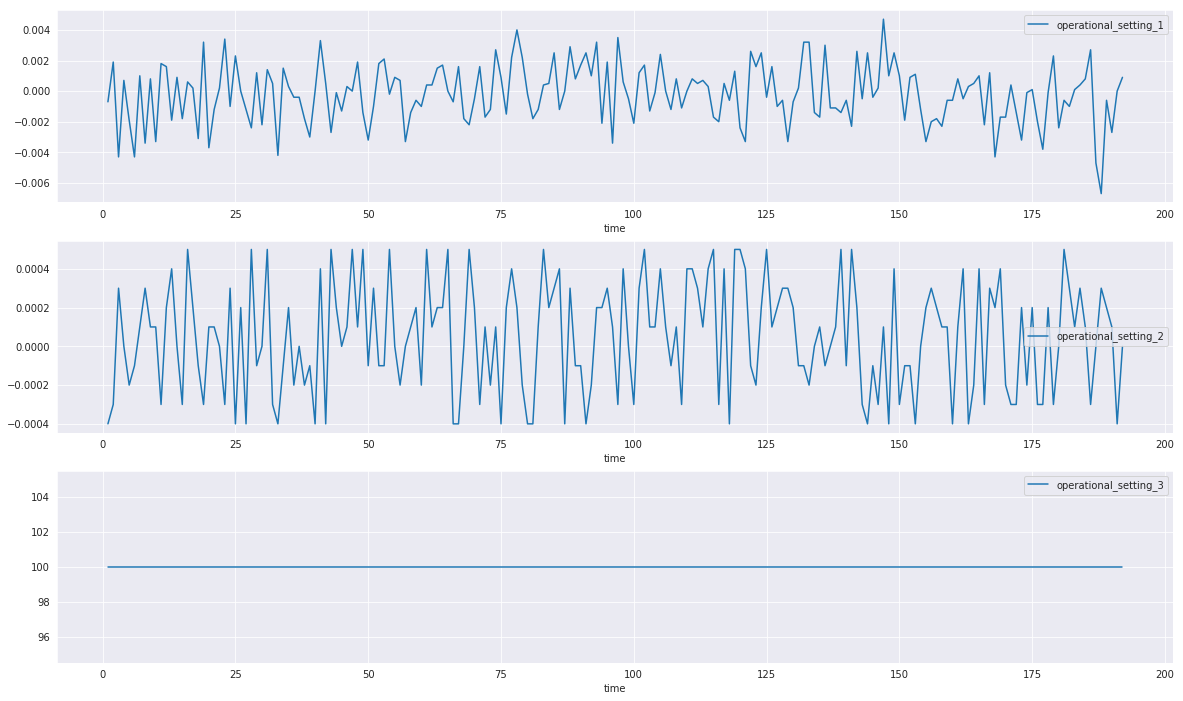

In [4]:
unit = 1 # Engine number to analyze
unit_data = train_data.loc[(unit)]

fig1 = plt.figure(figsize=(20,12))
figures.append(fig1)
for i in range(3):
    plt.subplot(3, 1, i + 1)
    sns.lineplot(data=unit_data[['operational_setting_{}'.format(i+1)]])

**Comments:** it looks like `operation setting 3` is not changing over time for this first subset of data `(FD001.txt)`. If this is true for all units, this is an easy feature to remove from the modeling phase.

Now plotting sensors measurements for previously selected unit:

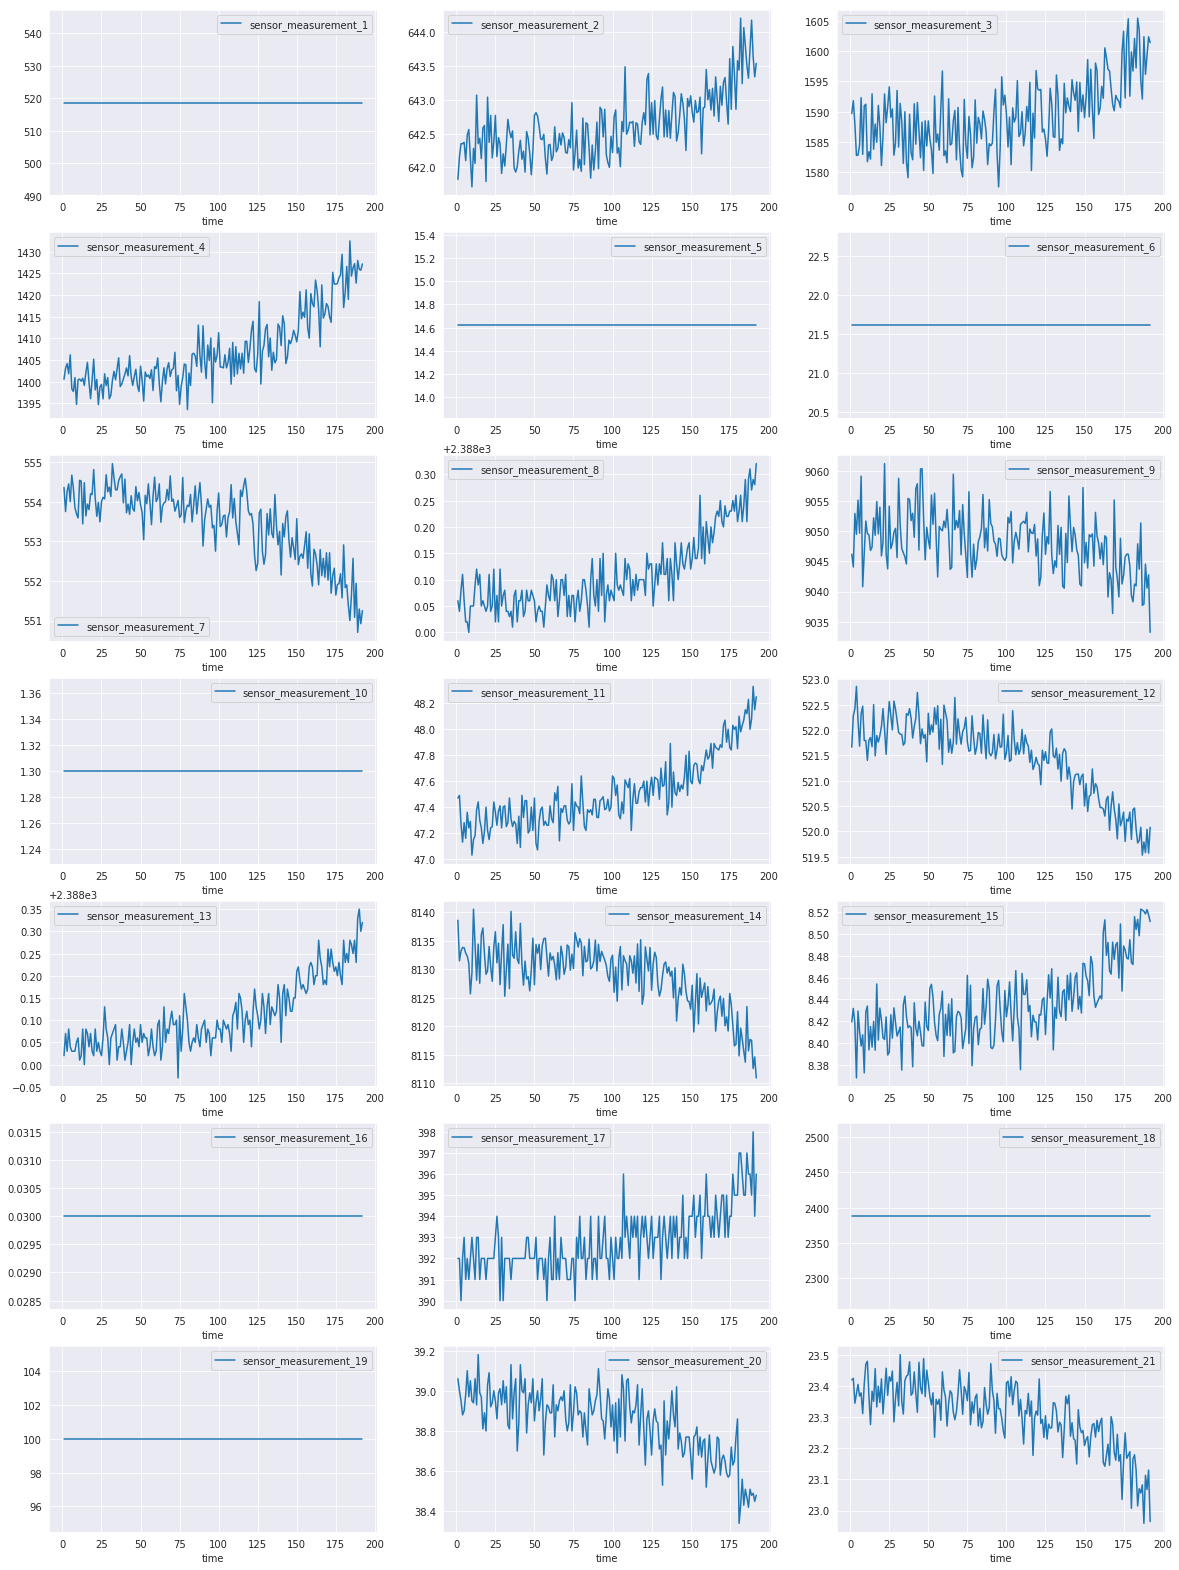

In [5]:
fig2 = plt.figure(figsize=(20,28))
figures.append(fig2)
for i in range(21):
    plt.subplot(7, 3, i + 1)
    sns.lineplot(data=unit_data[['sensor_measurement_{}'.format(i+1)]])

**Comments:**
* Checking the sensor measurements, it's pretty obvious when things are starting to go awry (around cycle 75 for unit 1 illustrated above).
* We can also note many signals have a low variance over time (it looks like they are even constant): checking over the whole dataset will help further simplifying it.

### Removing low variance features
#### Training dataset
Low variance columns (standard deviation lower than 1e-10) are removed from the dataset:

In [6]:
std = train_data.loc[:, 'operational_setting_1':].std()
features_to_remove = std[std <= 1e-10].index.tolist()
reduced_train_data = train_data.drop(columns=features_to_remove)
reduced_train_data.head()

true_rul  piecewise_rul  operational_setting_1  \
unit_number time                                                   
1           1          191            130                -0.0007   
            2          190            130                 0.0019   
            3          189            130                -0.0043   
            4          188            130                 0.0007   
            5          187            130                -0.0019   

                  operational_setting_2  sensor_measurement_2  \
unit_number time                                                
1           1                   -0.0004                641.82   
            2                   -0.0003                642.15   
            3                    0.0003                642.35   
            4                    0.0000                642.35   
            5                   -0.0002                642.37   

                  sensor_measurement_3  sensor_measurement_4  \
unit_number time                                               
1           1                  1589.70               1400.60   
            2                  1591.82               1403.14   
            3                  1587.99               1404.20   
            4                  1582.79               1401.87   
            5                  1582.85               1406.22   

                  sensor_measurement_6  sensor_measurement_7  \
unit_number time                                               
1           1                    21.61                554.36   
            2                    21.61                553.75   
            3                    21.61                554.26   
            4                    21.61                554.45   
            5                    21.61                554.00   

                  sensor_measurement_8  sensor_measurement_9  \
unit_number time                                               
1           1                  2388.06               9046.19   
            2                  2388.04               9044.07   
            3                  2388.08               9052.94   
            4                  2388.11               9049.48   
            5                  2388.06               9055.15   

                  sensor_measurement_11  sensor_measurement_12  \
unit_number time                                                 
1           1                     47.47                 521.66   
            2                     47.49                 522.28   
            3                     47.27                 522.42   
            4                     47.13                 522.86   
            5                     47.28                 522.19   

                  sensor_measurement_13  sensor_measurement_14  \
unit_number time                                                 
1           1                   2388.02                8138.62   
            2                   2388.07                8131.49   
            3                   2388.03                8133.23   
            4                   2388.08                8133.83   
            5                   2388.04                8133.80   

                  sensor_measurement_15  sensor_measurement_17  \
unit_number time                                                 
1           1                    8.4195                    392   
            2                    8.4318                    392   
            3                    8.4178                    390   
            4                    8.3682                    392   
            5                    8.4294                    393   

                  sensor_measurement_20  sensor_measurement_21  
unit_number time                                                
1           1                     39.06                23.4190  
            2                     39.00                23.4236  
            3                     38.95                23.3442  
            4           

In [7]:
reduced_train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
true_rul,20631.0,107.807862,68.880990,0.0000,51.0000,103.0000,155.0000,361.0000
piecewise_rul,20631.0,88.727304,43.444137,0.0000,51.0000,103.0000,130.0000,130.0000
operational_setting_1,20631.0,-0.000009,0.002187,-0.0087,-0.0015,0.0000,0.0015,0.0087
operational_setting_2,20631.0,0.000002,0.000293,-0.0006,-0.0002,0.0000,0.0003,0.0006
sensor_measurement_2,20631.0,642.680934,0.500053,641.2100,642.3250,642.6400,643.0000,644.5300
sensor_measurement_3,20631.0,1590.523119,6.131150,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
sensor_measurement_4,20631.0,1408.933782,9.000605,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
sensor_measurement_6,20631.0,21.609803,0.001389,21.6000,21.6100,21.6100,21.6100,21.6100
sensor_measurement_7,20631.0,553.367711,0.885092,549.8500,552.8100,553.4400,554.0100,556.0600
sensor_measurement_8,20631.0,2388.096652,0.070985,2387.9000,2388.0500,2388.0900,2388.1400,2388.5600


From the previous describe command, we can note that the different features have very different ranges. Normalization will be necessary if we want to get some results from our model.

#### Testing dataset
We also need to remove these features from the test data:

In [8]:
columns = train_data.reset_index().columns
reduced_test_data = test_data[columns]
reduced_test_data = reduced_test_data.set_index(['unit_number', 'time'])
reduced_test_data.head()

true_rul  piecewise_rul  operational_setting_1  \
unit_number time                                                   
1           1          142            130                 0.0023   
            2          141            130                -0.0027   
            3          140            130                 0.0003   
            4          139            130                 0.0042   
            5          138            130                 0.0014   

                  operational_setting_2  operational_setting_3  \
unit_number time                                                 
1           1                    0.0003                  100.0   
            2                   -0.0003                  100.0   
            3                    0.0001                  100.0   
            4                    0.0000                  100.0   
            5                    0.0000                  100.0   

                  sensor_measurement_1  sensor_measurement_2  \
unit_number time                                               
1           1                   518.67                643.02   
            2                   518.67                641.71   
            3                   518.67                642.46   
            4                   518.67                642.44   
            5                   518.67                642.51   

                  sensor_measurement_3  sensor_measurement_4  \
unit_number time                                               
1           1                  1585.29               1398.21   
            2                  1588.45               1395.42   
            3                  1586.94               1401.34   
            4                  1584.12               1406.42   
            5                  1587.19               1401.92   

                  sensor_measurement_5  ...  sensor_measurement_12  \
unit_number time                        ...                          
1           1                    14.62  ...                 521.72   
            2                    14.62  ...                 522.16   
            3                    14.62  ...                 521.97   
            4                    14.62  ...                 521.38   
            5                    14.62  ...                 522.15   

                  sensor_measurement_13  sensor_measurement_14  \
unit_number time                                                 
1           1                   2388.03                8125.55   
            2                   2388.06                8139.62   
            3                   2388.03                8130.10   
            4                   2388.05                8132.90   
            5                   2388.03                8129.54   

                  sensor_measurement_15  sensor_measurement_16  \
unit_number time                                                 
1           1                    8.4052                   0.03   
            2                    8.3803                   0.03   
            3                    8.4441                   0.03   
            4                    8.3917                   0.03   
            5                    8.4031                   0.03   

                  sensor_measurement_17  sensor_measurement_18  \
unit_number time                                                 
1           1                       392                   2388   
            2                       393                   2388   
            3                       393                   2388   
            4                       391                   2388   
            5                       390                   2388   

                  sensor_measurement_19  sensor_measurement_20  \
unit_number time                                                 
1           1                     100.0                  38.86   
            2                     100.0                  39.02   
            3                     10

## Cleanup
---

### Storing data for the next notebook

In [9]:
%store reduced_train_data
%store reduced_test_data

Stored 'reduced_train_data' (DataFrame)
Stored 'reduced_test_data' (DataFrame)


### Persisting these data to disk
This is useful in case you want to be able to execute each notebook independantly (from one session to another) and don't want to reexecute every notebooks whenever you want to focus on a particular step.

In [10]:
# Create the local path for our artifacts:
local_path = '../data/interim'
os.makedirs(local_path, exist_ok=True)

# Write the updated dataframe:
reduced_train_data.to_csv(os.path.join(local_path, 'reduced_train_data.csv'), index=True)
reduced_test_data.to_csv(os.path.join(local_path, 'reduced_test_data.csv'), index=True)

### Memory cleanup

In [11]:
import gc

for fig in figures:
    fig.clear()
    plt.close(fig)
    
_ = gc.collect()